In [1]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
RandomSeed = 1233
np.random.seed(RandomSeed)
tf.set_random_seed(RandomSeed)

In [3]:
class PtPINN:
    def __init__(self, x, t, u, lb, ub, lb1, ub1,layers,weights_values,biases_values):
        
        X = np.concatenate([x, t], 1)

        self.X = X
        
        self.x = X[:,0:1]
        self.t = X[:,1:2]
        
        self.u = u
        self.hsadasjd=0 
        self.lb = lb
        self.ub = ub
        
        self.lb1 = lb1
        self.ub1 = ub1
        

        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers) 
        
        self.weights_values = weights_values        
        self.biases_values = biases_values          
        
        # Calculate the values and convert them to float64
        value_float64 = 3.0/4
        self.b = tf.Variable(value_float64, dtype=tf.float64)
        
        value_float64=  1.0/(math.cosh(5*0.5)-1)       
        
        self.a = tf.constant(value_float64, dtype=tf.float64)     

        
        
        self.hh=[]
        self.hh1=[]
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))    

        self.x_f_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        
        self.x_lb_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_b_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        self.x_ub_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.x_tf = tf.placeholder(tf.float64, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float64, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float64, shape=[None, self.u.shape[1]])

        self.u_pred, _, _ = self.net_CE(self.x_tf, self.t_tf)
        self.u_lb_pred, _, _ = self.net_CE(self.x_lb_tf, self.t_b_tf)
        self.u_ub_pred, _, _ = self.net_CE(self.x_ub_tf, self.t_b_tf)

        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        

        
        self.lossS = tf.reduce_mean(tf.square(self.u_tf - self.u_pred))
                                              
        self.lossB = tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred))
                                             
        self.lossfu = tf.reduce_mean(tf.square(self.f_pred))
        

        self.optimizer_Adam = tf.train.AdamOptimizer()

        
        self.loss  =  self.lossS + 20* self.lossB + self.lossfu
        

        
        
        
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)      
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
    
        init = tf.global_variables_initializer()
        self.sess.run(init)
        self.save = tf.train.Saver(max_to_keep=1)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.zeros([layers[l], layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float64), dtype=tf.float64)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=tf.float64))
    
    
    
    def custom_function(self,t):
        
        ab= self.b     
        
        condition2 = tf.less_equal(t, 0.5)
        condition3 = tf.less_equal(t, ab)
      
        B=1/(ab-0.5)*(t-0.5)
        
        return tf.where(condition2, tf.zeros_like(t), tf.where(condition3, -2*B**3+3*B**2,tf.zeros_like(t)+1))
    
    
    def neural_net(self, x,t, weights, biases,weights_values,biases_values):
        
        num_layers = len(weights) + 1
        X = tf.concat([x,t],1)
        H = 2.0*(X - self.lb1)/(self.ub1 - self.lb1) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            W1 = weights_values[l]
            b1 = biases_values[l]   
            
            H0 = tf.add(tf.matmul(H, W), b)
            H1 = tf.add(tf.matmul(H, W1), b1)
            
            B = self.custom_function(t)   
            H0 = H0*B              
            
            H  = tf.add(H0,H1)
            H =  tf.tanh(H)
        
        W = weights[-1]
        b = biases[-1]
        W1 = weights_values[-1]
        b1 = biases_values[-1]  
        
        H0 = tf.add(tf.matmul(H, W), b)
        
        B = self.custom_function(t)   
        H0 = H0*B            
        
        H1 = tf.add(tf.matmul(H, W1), b1) 
        H  = tf.add(H0,H1)      
        Y = H
        
        return Y
    
    def net_CE(self, x, t):
        X = tf.concat([x,t],1)
        u = self.neural_net(x,t, self.weights, self.biases,self.weights_values, self.biases_values)
        u_x = tf.gradients(u, x)[0]
        u_t = tf.gradients(u, t)[0]
        return u, u_x, u_t

    def net_f(self, x, t):
        u, u_x, u_t = self.net_CE(x, t)
        f_u = u_t + 40*u_x 
        return f_u
    
 
    
    
    def callback(self, loss, a,b,lossfu, lossS, lossB):
        sss=self.hsadasjd
        if sss%1000==0:
            print('Loss: %.6e, Lossfu: %.3e, LossS: %.3e, LossB: %.3e ' % (loss, lossfu, lossS, lossB))
        sss=sss+1
        self.hsadasjd=sss 
        self.hh.append(a)      
        self.hh1.append(b) 
    def train(self, nIter, Nf, Nn, Nb):

        X_train = self.lb + (self.ub-self.lb)*lhs(2, Nf)
        self.xtrain_f = X_train[:,0:1]
        self.ttrain_f = X_train[:,1:2] 
        
        X_lb_train = self.lb + [0,self.ub[1]-self.lb[1]]*lhs(2, Nb)
        self.xtrain_lb = X_lb_train[:,0:1]
        self.ttrain_b = X_lb_train[:,1:2]
        
        X_ub_train = [self.ub[0],0] + [0,self.ub[1]-self.lb[1]]*lhs(2, Nb)
        self.xtrain_ub = X_ub_train[:,0:1]
        
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u,
                   self.x_lb_tf: self.xtrain_lb, self.t_b_tf: self.ttrain_b, 
                   self.x_ub_tf: self.xtrain_ub, 
                   self.x_f_tf: self.xtrain_f, self.t_f_tf: self.ttrain_f}

        start_time = time.time()
        
        for it in range(nIter):
            
                ab= self.sess.run(self.a)
                self.hh.append(ab)       
                abc= self.sess.run(self.b)
                self.hh1.append(abc)                 
                
                print(abc)             
            
                loss_value = self.sess.run(self.loss, tf_dict)
                lossfu = self.sess.run(self.lossfu, tf_dict)
                lossS = self.sess.run(self.lossS, tf_dict)
                lossB = self.sess.run(self.lossB, tf_dict)
                self.sess.run(self.train_op_Adam, tf_dict)
           
                
                if it % 1000 == 0:
                    print('It: %d, Loss: %.6e, Lossfu: %.3e, LossS: %.3e, LossB: %.3e' % (it, loss_value, lossfu, lossS, lossB))
            
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, method = 'L-BFGS-B', options = {'maxiter': 50000,'maxfun': 50000,'maxcor': 50,'maxls': 50,'ftol' : 1.0 * np.finfo(float).eps})                                                                                                         
        self.optimizer.minimize(self.sess, feed_dict = tf_dict, fetches = [self.loss,self.a,self.b,  self.lossfu, self.lossS, self.lossB], loss_callback = self.callback)        
                                    
    
    def predict(self, x, t):
        
        tf_dict = {self.x_tf: x, self.t_tf: t}
        u_star = self.sess.run(self.u_pred, tf_dict)
        
        return u_star

    def saver(self, string):
        self.save.save(self.sess, 'ckpt/'+string)

    def sssss(self):
        return self.hh,  self.hh1  
        
    def restore(self):
        model_file = tf.train.latest_checkpoint('ckpt/')
        self.save.restore(self.sess, model_file)

In [4]:
import pickle

In [5]:
with open('weights.pkl', 'rb') as f:
    weights_values = pickle.load(f)

In [6]:
with open('weights1.pkl', 'rb') as f:
    biases_values = pickle.load(f)

In [7]:
if __name__ == "__main__": 
    # Doman bounds
    lb = np.array([0, 0])
    ub = np.array([2*np.pi, 1.0])
    
    lb1 = np.array([0, 0])
    ub1 = np.array([2*np.pi, 0.5])    
    
    Nb = 100
    N0 = 400
    
    layers = [2,100,100,100,100,1]
    
    def Exact_Solution(x, t):
        u = np.sin(x-40*t)
        return u

    N0 = 1200
    x=np.linspace(0,2*np.pi,N0).flatten()[:,None]  
    X0 =x
    T0 = np.full((N0,1), lb1[1])
    u0 = Exact_Solution(X0,T0)

In [8]:
    model = PtPINN(X0, T0, u0, lb, ub, lb1, ub1, layers,weights_values,biases_values)                          
    model.train(5000, 10000, 1200, 1200)             

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
0.75
It: 0, Loss: 4.571614e+00, Lossfu: 1.306e-03, LossS: 6.677e-08, LossB: 2.285e-01
0.75
0.750744134285334
0.7515574782047774
0.7524185678198639
0.7527185894371744
0.7529201885856963
0.7531741792365387
0.7532428407656812
0.7531395631616452
0.7530581824087667
0.7530361645582637
0.7530095960785109
0.7530041509646641
0.753074896719874
0.7531816151413336
0.7532556699960111
0.7532969500410562
0.7533218795040616
0.7532788826180606
0.7531018004201625
0.7527968994743595
0.7524047971005672
0.7519337551108927
0.7513702221932347
0.7507243592082182
0.7500256664379736
0.7492915629415079
0.7485219470918165
0.7477223325004912
0.7469073770594884
0.7460838660464376
0.7452517641481042
0.7444198138024984
0.7435984181720178
0.742779793783251
0.7419466909152798
0.7410930476221131
0.7402208571330124
0.7393298974171543
0.7384237201407636
0.7375146019475035
0.7366118190574055
0.73571365572

0.5669763053736012
0.5666496548846416
0.5662992989068434
0.5659614854084825
0.5656211133310224
0.5652653651671952
0.5649387921367849
0.5645890746632938
0.5642893901064621
0.5639599252588445
0.5636948413991925
0.563393006083864
0.5631806794015644
0.5629276695775736
0.5628382030413109
0.5627233876864195
0.562953225893335
0.5632580858266101
0.5641242389741407
0.5650571219945183
0.5661775013457399
0.5671132603635102
0.5678823291439307
0.5687953498271792
0.5695537548226087
0.5701750695094014
0.5708220637724556
0.5713210211075705
0.5717258948390705
0.5721087373925011
0.5723613321741157
0.572548502882744
0.5727056065022736
0.5727533906923128
0.5727552772728592
0.572731326150714
0.5726125315260544
0.5724639068323456
0.5723056083611757
0.5720725111005706
0.5718248743044869
0.5715776967411912
0.5712735819809232
0.5709671353785303
0.5706553744573699
0.5702979441444582
0.5699541101980623
0.5695990235106482
0.5692065557365038
0.5688414601460615
0.568463281668328
0.5680618364315175
0.567698425412567

0.5536914664869115
0.553568459428443
0.5534486756165264
0.5533318777396067
0.5532172388018063
0.5531048226130634
0.5529942415762231
0.5528848884978586
0.5527766751115233
0.5526697114321703
0.552563764889833
0.5524590400081608
0.552354660479031
0.5522511355511949
0.5521484381272709
0.5520460288036368
0.5519443483073398
0.5518428209976284
0.5517418201262492
0.5516412340828462
0.5515404093562832
0.5514387375141669
0.5513357819941889
0.551231255440412
0.5511257091523449
0.5510187067483443
0.5509109744940935
0.5508020724026844
0.5506922512465853
0.5505815508691778
0.5504699509832659
0.55035840348506
0.5502465132890537
0.550134428219693
0.5500225441031793
0.5499105069115559
0.5497992037559906
0.5496874841183451
0.5495751247717777
0.5494610224669292
0.5493456289785679
0.5492295602165214
0.5491125305829779
0.5489946120626924
0.5488758302884318
0.5487563466682599
0.5486356767891879
0.5485137070040352
0.5483919879472134
0.5482698771686034
0.5481471708977668
0.5480245876868064
0.5479028385835928


0.5854607654165533
0.5852353913150015
0.5850052163954639
0.5847621506852845
0.5845031667871451
0.5842339346030971
0.5839649281055519
0.5836979986763183
0.5834246212446093
0.5831444122510931
0.5828632859657208
0.5825880302601646
0.5823146955500811
0.5820342813708952
0.5817472717535741
0.5814620045556542
0.5811865691844763
0.5809168590423395
0.5806443007894789
0.5803679993460721
0.5800943936560221
0.5798292214639242
0.5795689399048373
0.5793080094427793
0.5790461208471537
0.5787880517196727
0.5785375546099804
0.5782919235151824
0.5780485013631206
0.5778069669913581
0.5775694377271928
0.5773357990032318
0.5771046282578742
0.5768758999938153
0.5766507318399562
0.576429830981395
0.5762117278447835
0.5759960071915761
0.5757840567913335
0.5755769537050051
0.5753733399180974
0.5751710624763761
0.5749704763494785
0.5747738451454638
0.5745820318369423
0.5743929431029074
0.5742044884665207
0.5740173811277541
0.5738331952101451
0.5736518796278539
0.573471894277229
0.5732927822803737
0.573115538666

0.5517762048881888
0.5517148761400172
0.5516524185210672
0.5515920246380024
0.5515303011902479
0.5514687357583528
0.5514080233188541
0.5513459914901204
0.5512850578125247
0.5512237578146809
0.5511619448405114
0.5511016523901761
0.5510409448990115
0.5509808304335799
0.5509213409382151
0.5508612965386588
0.5508023148558595
0.5507432136977334
0.5506841193955053
0.5506259281062205
0.5505674452817205
0.5505096649616501
0.5504521431581778
0.5503947952118693
0.5503383851539565
0.550281968823972
0.5502261941756432
0.5501707650840395
0.550115467349553
0.5500608652163567
0.5500062636496129
0.5499523848792836
0.5498989451653019
0.5498456796464942
0.5497929069099615
0.5497401810631246
0.5496878530434542
0.549635614240243
0.5495832960206326
0.5495309957744023
0.5494785483848345
0.5494261514046602
0.5493737677676193
0.5493215171131725
0.5492694803630315
0.5492176413836184
0.5491660099739955
0.549114635727508
0.5490634752799284
0.5490125028780066
0.5489616000430443
0.54891085617088
0.5488600413326225

0.5528255643278115
0.5528039575156876
0.5527825471579714
0.5527613404329408
0.5527403353660204
0.5527195345286743
0.5526989333710354
0.5526785339264957
0.5526583326512664
0.5526383335251419
0.5526185311523965
0.5525989289735803
0.5525795212217027
0.5525603105489928
0.5525413170075961
0.55252253747225
0.5525039670702693
0.5524856032448824
0.5524674413967366
0.5524494798289169
0.5524317149670362
0.5524141439495104
0.5523967736533467
0.5523795987461733
0.5523626180663656
0.5523457827389139
0.5523290961622445
0.5523125577972552
0.5522961715399065
0.5522799348995943
0.5522638139911582
0.5522478090168741
0.5522319290797256
0.552216173197034
0.5522005504419691
0.552185057436192
0.5521697047750456
0.55215448535168
0.5521394128772072
0.5521244757318517
0.5521096919591953
0.552095054038735
0.5520805866187104
0.5520662587151282
0.5520521096277983
0.552038089286369
0.5520242615961384
0.5520105448773386
0.5519970453718251
0.5519835176900443
0.5519701481809557
0.5519567069570828
0.5519434869067726
0

0.5582705817716096
0.5581646650077794
0.5580604842715436
0.5579594244959404
0.557859626963326
0.5577621979401763
0.557667073879568
0.557573357212353
0.5574824008204267
0.5573930847028213
0.5573056115530071
0.557220504819999
0.5571367579619336
0.5570552611742591
0.5569755353702733
0.5568974222512811
0.5568215572625476
0.5567470887100352
0.5566745397635118
0.5566036997643639
0.5565343090468632
0.5564668894715387
0.5564007742997769
0.5563362947457156
0.5562733228494434
0.5562115665544767
0.5561514200856966
0.5560923867700861
0.5560347318299769
0.5559783457523929
0.5559230009628126
0.5558689730745765
0.5558158765481558
0.5557639309784917
0.5557130035142164
0.5556629846489468
0.5556140446085084
0.5555659094227383
0.5555187625460346
0.5554724406005629
0.5554269318060838
0.5553823036272117
0.5553383681955031
0.555295273935779
0.5552528090071417
0.5552110340853615
0.5551699268633803
0.5551293986163116
0.555089552047651
0.5550502389082327
0.5550115510965244
0.5549733955696324
0.5549357762935394

0.5553688980403283
0.5553196679987246
It: 3000, Loss: 6.041132e-03, Lossfu: 3.625e-03, LossS: 6.677e-08, LossB: 1.208e-04
0.5552719960936127
0.5552240893710445
0.5551777496084517
0.5551312200287017
0.5550861486598785
0.5550410738571665
0.5549972008939207
0.5549535578515413
0.5549110230758237
0.5548689047410418
0.5548277672593087
0.5547870318910546
0.554747274404207
0.5547079540529387
0.5546695521450259
0.5546316320430676
0.5545945712076408
0.5545579758520922
0.5545222076461362
0.5544868293088677
0.5544523982123701
0.5544181896748168
0.5543851229241635
0.554352096090967
0.5543204814246933
0.5542885845274034
0.5542586056496835
0.5542280173256343
0.5542005174030343
0.5541719997625256
0.554149297665507
0.5541257638638595
0.5541148843022027
0.5541069829251629
0.5541309696246279
0.55417690495658
0.5543117188654332
0.554538385235311
0.5550029509403552
0.5557140389448119
0.5568242847050068
0.5581205055365555
0.5594805051032357
0.5606815852408197
0.5617740134821961
0.5629398045791285
0.56396424

0.5558987397974842
0.5558724898819402
0.5558466090683658
0.5558210689177085
0.5557958904098319
0.5557710379463648
0.555746502816105
0.5557222694009195
0.5556983288440759
0.5556746890699931
0.5556513262081004
0.5556282575101958
0.5556054593246167
0.5555829445475281
0.555560705025914
0.5555387369920647
0.5555170409005973
0.5554955998547199
0.555474423902161
0.5554534887790831
0.5554328067281682
0.5554123602130426
0.5553921538858956
0.5553721816249977
0.5553524368946186
0.5553329233886528
0.5553136279244788
0.5552945593832725
0.5552756840359404
0.5552570111620717
0.5552385311058925
0.5552202470872349
0.5552021552407178
0.5551842530566807
0.5551665421432498
0.5551490152634957
0.5551316766854513
0.5551145178890619
0.5550975430069489
0.5550807345224219
0.5550640951511915
0.5550476200465734
0.55503130919611
0.5550151600950849
0.5549991706649109
0.5549833407975965
0.5549676664080585
0.5549521489235024
0.5549367831588936
0.554921570962599
0.5549065070408016
0.5548915868380354
0.5548768058675952

0.5562724652241899
0.5562486171323343
0.5562250667476665
0.5562018539872459
0.5561789378401605
0.5561563478161471
0.5561340505894937
0.5561120610517153
0.5560903632952995
0.5560689439273083
0.5560478200488477
0.5560269578127912
0.5560063803817102
0.5559860481414353
0.5559659829712883
0.5559461505818482
0.5559265918752715
0.5559072659162375
0.5558881959977054
0.5558693578086474
0.5558507588460578
0.5558323839455832
0.5558142472152795
0.5557963329698555
0.5557786437261901
0.5557611475521786
0.5557438376290966
0.5557267181399859
0.5557097803137131
0.5556930277420304
0.5556764508675403
0.5556600589084116
0.5556438336149095
0.555627792977869
0.5556119150701168
0.5555962163152427
0.5555806738648054
0.5555653165894019
0.555550111118208
0.5555350903143763
0.5555202088202492
0.5555055117623021
0.555490940758286
0.5554765573940178
0.555462279169774
0.5554482020488649
0.5554342032049675
0.555420428321901
0.5554066940054133
0.5553932243661016
0.5553797344861311
0.5553665832454509
0.555353312638919

0.5584421988279855
0.558401153936625
0.5583608440077998
0.5583211889990229
0.5582823011829229
0.5582439880697551
0.5582064173741718
0.558169477945842
0.558133120466511
0.5580974680382574
0.5580623214486713
0.5580277875844292
0.5579938111215627
0.5579603328449327
0.5579274324820188
0.557894986011402
0.5578630758834634
0.5578316187970795
0.5578006233624218
0.5577701111662994
0.5577400080075324
0.557710377849286
0.5576811455707159
0.5576523453854825
0.5576239071646018
0.5575958283506658
0.5575681276615599
0.5575407487173241
0.5575137502497521
0.5574870707873261
0.5574607135094468
0.5574346831346122
0.557408940005224
0.5573835324916472
0.5573584096572323
0.5573335792009597
0.5573090324706126
0.5572847516989622
0.5572607666728053
0.5572370374651434
0.5572135974823599
0.557190418203234
0.5571675001613744
0.5571448391550239
0.5571224273951421
0.5571002767758859
0.5570783688530832
0.5570567209084389
0.5570353112247768
0.5570141573821645
0.5569932449361822
0.5569725748241653
0.5569521529753403


0.5718345866434942
0.5715359801817184
0.5712596890453498
0.5709598474541764
0.5706415959656171
0.570349934468437
0.5700398748209023
0.5697218594616031
0.5694288071100494
0.5691214443880028
0.5688136716681413
0.5685262028199105
0.5682295137859107
0.5679367115138767
0.5676596781521352
0.5673769024956776
0.5671005894817611
0.5668369616530239
0.5665700037694655
0.5663124394610182
0.5660642201314726
0.5658139965290451
0.5655757849079616
0.5653433735362715
0.5651113381970593
0.5648927232353543
0.5646770297346974
0.5644648499912263
0.5642648319459321
0.5640664489159335
0.5638750186792322
0.5636919097170745
0.5635104507067645
0.5633380471830873
0.5631700253094895
0.5630052273752775
0.5628493786460829
0.5626957525376676
0.5625474815873575
0.5624055134226632
0.5622653780243323
0.5621320614492259
0.562002252878655
0.5618752931814167
0.5617544116772607
0.5616354960033924
0.5615209130701024
0.5614103830567194
0.5613018896857777
0.561198309158634
0.5610970032381726
0.5609988080799282
0.5609044906635

Loss: 6.546569e-06, Lossfu: 5.662e-06, LossS: 6.677e-08, LossB: 4.087e-08 
Loss: 6.397293e-06, Lossfu: 5.471e-06, LossS: 6.677e-08, LossB: 4.299e-08 
Loss: 6.290652e-06, Lossfu: 5.322e-06, LossS: 6.677e-08, LossB: 4.512e-08 
Loss: 6.191045e-06, Lossfu: 5.181e-06, LossS: 6.677e-08, LossB: 4.714e-08 
Loss: 6.061745e-06, Lossfu: 5.034e-06, LossS: 6.677e-08, LossB: 4.803e-08 
Loss: 5.972059e-06, Lossfu: 4.966e-06, LossS: 6.677e-08, LossB: 4.695e-08 
Loss: 5.847038e-06, Lossfu: 4.861e-06, LossS: 6.677e-08, LossB: 4.595e-08 
Loss: 5.742639e-06, Lossfu: 4.772e-06, LossS: 6.677e-08, LossB: 4.518e-08 
Loss: 5.653135e-06, Lossfu: 4.698e-06, LossS: 6.677e-08, LossB: 4.440e-08 
Loss: 5.565317e-06, Lossfu: 4.642e-06, LossS: 6.677e-08, LossB: 4.280e-08 
Loss: 5.492336e-06, Lossfu: 4.586e-06, LossS: 6.677e-08, LossB: 4.196e-08 
Loss: 5.434241e-06, Lossfu: 4.514e-06, LossS: 6.677e-08, LossB: 4.269e-08 
Loss: 5.360592e-06, Lossfu: 4.468e-06, LossS: 6.677e-08, LossB: 4.127e-08 
Loss: 5.236450e-06, Lossf

In [9]:
    x=np.linspace(0,2*np.pi,1200).flatten()[:,None]   
    t=np.linspace(0,0.5,1200).flatten()[:,None]  
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_pred1=model.predict(X_star[:,0:1],X_star[:,1:2])
    u_star1 = Exact_Solution(X_star[:,0:1],X_star[:,1:2])
    u_star=u_star1.flatten()[:,None]  
    u_pred=u_pred1.flatten()[:,None] 
    error_u1 = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_u2 = np.linalg.norm(u_star-u_pred,1)/len(u_star)
    error_u3 = np.linalg.norm(u_star-u_pred,np.inf)
    print('二范数Error u: %e' % (error_u1))
    print('平均绝对Error u: %e' % (error_u2))
    print('无穷范数Error u: %e' % (error_u3))

二范数Error u: 3.979398e-04
平均绝对Error u: 2.394529e-04
无穷范数Error u: 7.269167e-04


In [18]:
    x=np.linspace(0,2*np.pi,1200).flatten()[:,None]   
    t=np.linspace(0,1,1200).flatten()[:,None]  
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_pred1=model.predict(X_star[:,0:1],X_star[:,1:2])
    u_star1 = Exact_Solution(X_star[:,0:1],X_star[:,1:2])
    u_star=u_star1.flatten()[:,None]  
    u_pred=u_pred1.flatten()[:,None] 
    error_u1 = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_u2 = np.linalg.norm(u_star-u_pred,1)/len(u_star)
    error_u3 = np.linalg.norm(u_star-u_pred,np.inf)
    print('二范数Error u: %e' % (error_u1))
    print('平均绝对Error u: %e' % (error_u2))
    print('无穷范数Error u: %e' % (error_u3))
    u_star=u_star1.flatten()[:,None] 
    Exact =u_star.reshape(1200,1200).T   

二范数Error u: 5.604637e-04
平均绝对Error u: 3.290517e-04
无穷范数Error u: 2.766919e-03


In [19]:
    scipy.io.savemat("duiliuaednn.mat", {'u': u_pred})

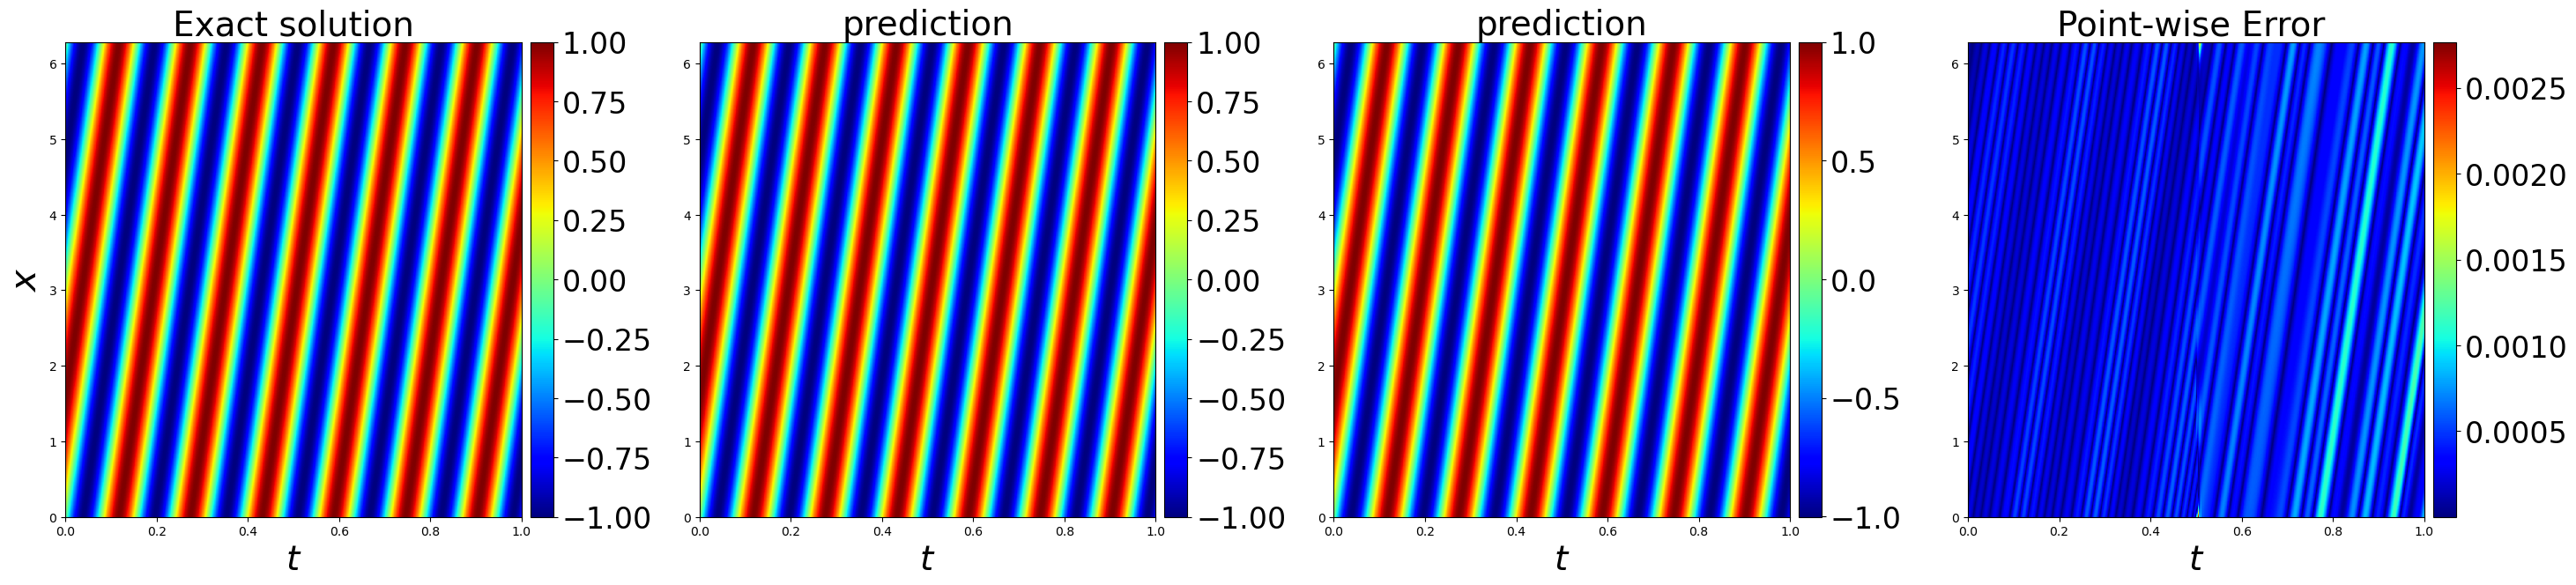

In [20]:
    lb = np.array([0, 0])
    ub = np.array([2*np.pi, 1])

    Exact_h=Exact 

    U_preds=u_pred.reshape(1200,1200).T    

    fig, axs = plt.subplots(1, 4, figsize=(35, 7))
    fig.subplots_adjust(wspace=0.3)  # 调整子图之间的水平间距

    # 第一个子图
    ax1 = axs[2]    
    h = ax1.imshow(U_preds, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax1.set_title(r'prediction', fontsize=28)
    ax1.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)   
    
    
    # 第一个子图
    ax1 = axs[1]    
    h = ax1.imshow(U_preds, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto',vmin=Exact.min(),vmax=Exact.max())
    ax1.set_title(r'prediction', fontsize=28)
    ax1.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)      
    
    
    
    ax2 = axs[0]    
    h = ax2.imshow(Exact, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax2.set_title('Exact solution', fontsize=28)
    ax2.set_xlabel('$t$', fontsize=28)
    ax2.set_ylabel('$x$', fontsize=30)
    #左边的色差图
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)       
    
    ax3 = axs[3]    
    h = ax3.imshow(np.abs(Exact-U_preds), interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='auto')
    ax3.set_title(r'Point-wise Error ', fontsize=28)
    ax3.set_xlabel('$t$', fontsize=28)
    #左边的色差图
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(h, cax=cax)  

    cbar.ax.tick_params(labelsize=24)     
    
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    #plt.savefig('0_15_exact_solution_and_point_wise_error_by_mmpinn_and_standard.pdf', bbox_inches='tight') 
    plt.show() 

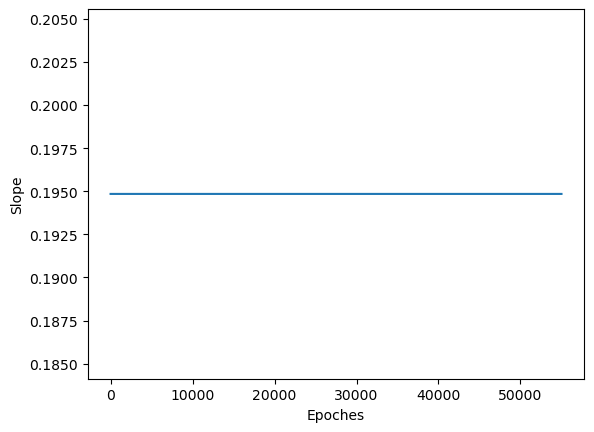

In [21]:
    xielv,ss=model.sssss()
    x=np.arange(1,len(xielv)+1)
    plt.plot(x,xielv)
    plt.xlabel('Epoches')
    plt.ylabel('Slope')
    plt.show()

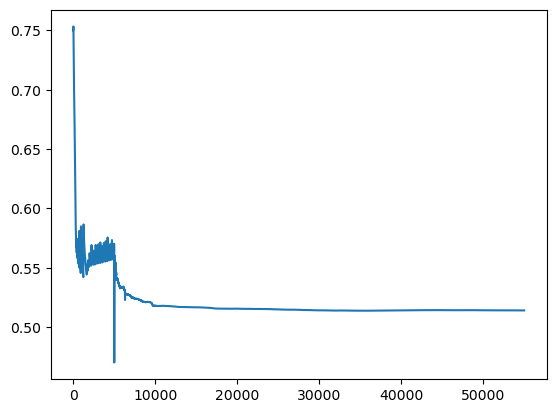

In [22]:
    xielv,ss=model.sssss()
    x=np.arange(1,len(ss)+1)
    plt.plot(x,ss)
    plt.show()

In [23]:
    xielv,ss=model.sssss()    
    scipy.io.savemat("aegnna.mat", {'egpinna': xielv})
    scipy.io.savemat("aegnnb.mat", {'egpinnb': ss})

In [24]:
a= model.sess.run(model.b)
a

0.514024620893676

In [25]:
a= model.sess.run(model.a)
a

0.19484481613175275